In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'blood-cell-cancer-all-4class:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1683013%2F2758382%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240602%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240602T131312Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D70859822b64ad6cf08f08adf0659b3ac155b333fab73d9fdee02c6ad3578e5fa39d1bc6cf2fd9b08940e6f506d0fbbc40c7002ba01585b7df65662a5cd311f17bb9c81010addeaa0a445d082858ab81444cf27fcf09b85d84b51a1f8c2beb33fb7f7f0a05fefed7a361577f8f76a884d69e356038a9ffb42a080a1c2d4e8cf035b45755c5ba17f8da34dbfa11f8638b94a4e7f88ab7a96812b6063bc3bada67a96fe8d00ff91c59b99ca7506b20722b81966b21620c54ddd20805a2e8ce374e5b0a7118cd637aa0e47bbe2329e934ae43438bfadf137166e8f3919632dc3377d905029bd07444da2e91e9a797eae4c0814e611c19e4a68fc6942d6d09e0a66ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

Benign_dir = [ r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/Benign']

Malignant_Pre_B_dirs = [
    r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pre-B'
]

Malignant_Pro_B_dirs = [
    r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pro-B'
]

Malignant_early_Pre_B_dirs = [
    r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] early Pre-B'
]

filepaths = []
labels = []
dict_lists = [Benign_dir, Malignant_Pre_B_dirs,Malignant_Pro_B_dirs, Malignant_early_Pre_B_dirs]
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths  labels
0  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
1  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
2  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
3  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
4  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
labels
Malignant_early Pre-B    979
Malignant_Pre-B          955
Malignant_Pro-B          796
Benign                   512
Name: count, dtype: int64


In [ ]:
bloodCell_df.shape

(3242, 2)

In [ ]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(2593, 2)
(973, 2)
(649, 2)
(2269, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=8,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 2593 validated image filenames belonging to 4 classes.
Found 973 validated image filenames belonging to 4 classes.
Found 649 validated image filenames belonging to 4 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


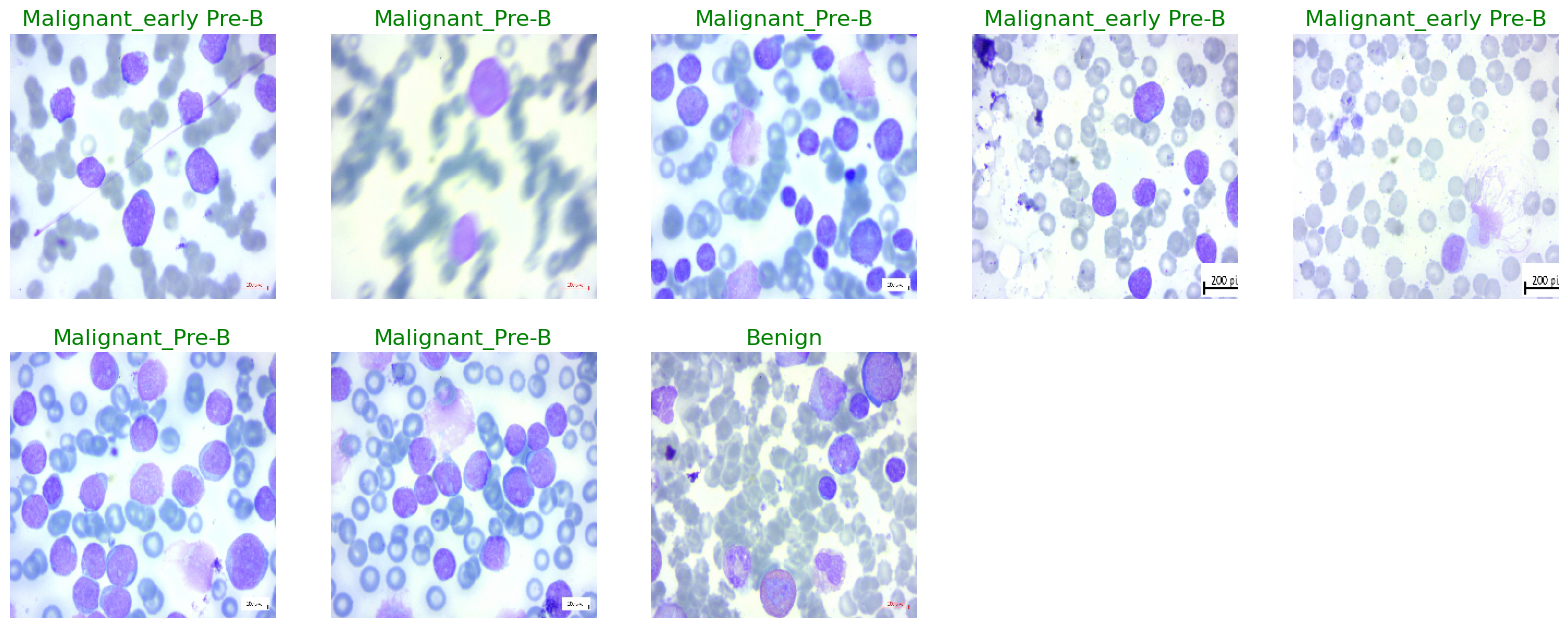

In [ ]:
def show_Blood_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Blood_images(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization_9 (Bat  (None, 73, 73, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_10 (Ba  (None, 73, 73, 256)       1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 256)       0         
 g2D)                                                            
                                                      

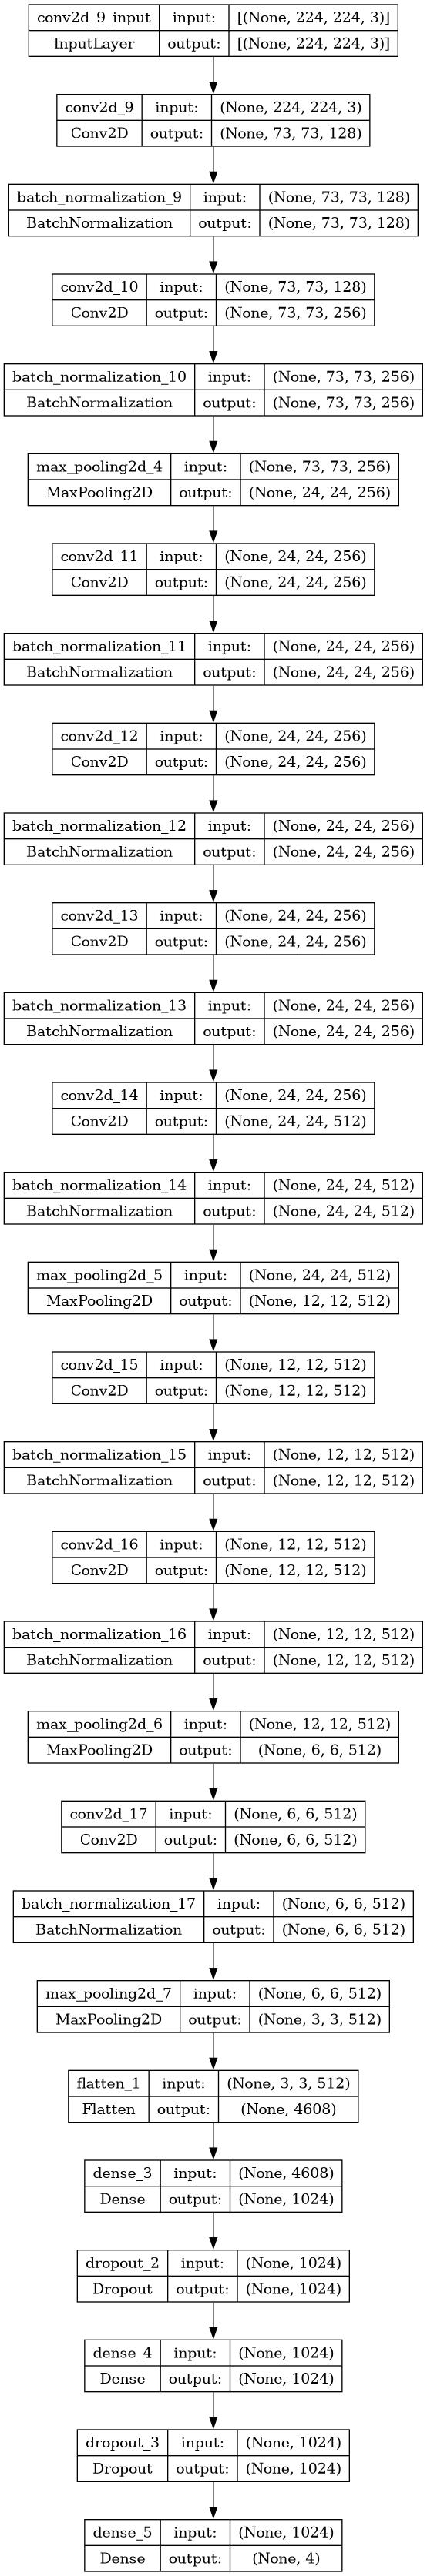

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
325/325 [==============================] - 1448s 4s/step - loss: 1.2276 - accuracy: 0.7231 - val_loss: 0.5812 - val_accuracy: 0.7673
Epoch 2/10
325/325 [==============================] - 1451s 4s/step - loss: 0.3633 - accuracy: 0.8766 - val_loss: 0.2762 - val_accuracy: 0.9029
Epoch 3/10
325/325 [==============================] - 1450s 4s/step - loss: 0.2108 - accuracy: 0.9252 - val_loss: 0.1863 - val_accuracy: 0.9492
Epoch 4/10
325/325 [==============================] - 1452s 4s/step - loss: 0.1611 - accuracy: 0.9479 - val_loss: 0.1689 - val_accuracy: 0.9522
Epoch 5/10
325/325 [==============================] - 1392s 4s/step - loss: 0.1004 - accuracy: 0.9634 - val_loss: 0.1766 - val_accuracy: 0.9569
Epoch 6/10
325/325 [==============================] - 1438s 4s/step - loss: 0.1189 - accuracy: 0.9568 - val_loss: 0.1503 - val_accuracy: 0.9584
Epoch 7/10
325/325 [==============================] - 1453s 4s/step - loss: 0.0782 - accuracy: 0.9776 - val_loss: 0.1207 - val_accuracy:

In [ ]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

325/325 [==============================] - 1439s 4s/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.1444 - val_accuracy: 0.9599


In [ ]:
model.evaluate(test, verbose=1)

122/122 [==============================] - 137s 1s/step - loss: 0.1110 - accuracy: 0.9692


[0.11098901927471161, 0.9691675305366516]

In [ ]:
model.save("Blood Cell.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

122/122 [==============================] - 137s 1s/step


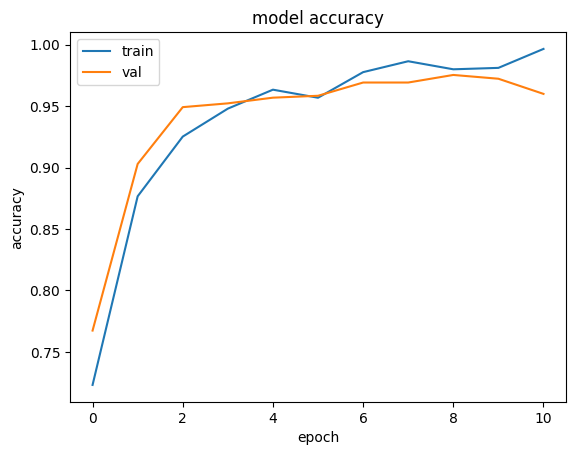

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

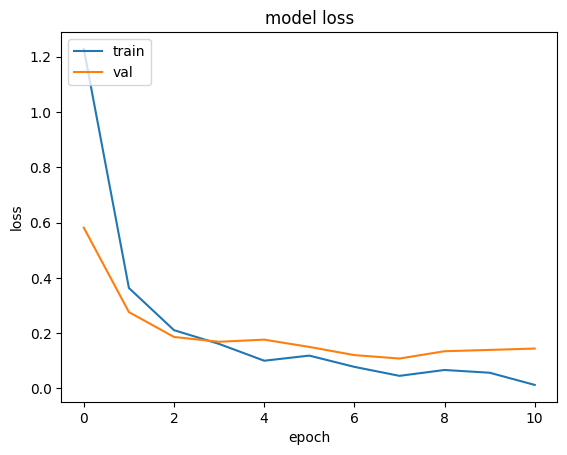

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

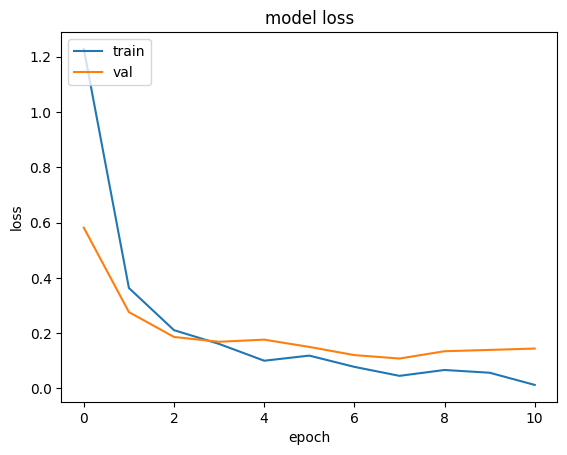

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                       precision    recall  f1-score   support

               Benign       0.96      0.92      0.94       173
      Malignant_Pre-B       0.98      0.96      0.97       286
      Malignant_Pro-B       0.97      1.00      0.98       223
Malignant_early Pre-B       0.96      0.99      0.97       291

             accuracy                           0.97       973
            macro avg       0.97      0.97      0.97       973
         weighted avg       0.97      0.97      0.97       973

Accuracy of the Model: 96.9%


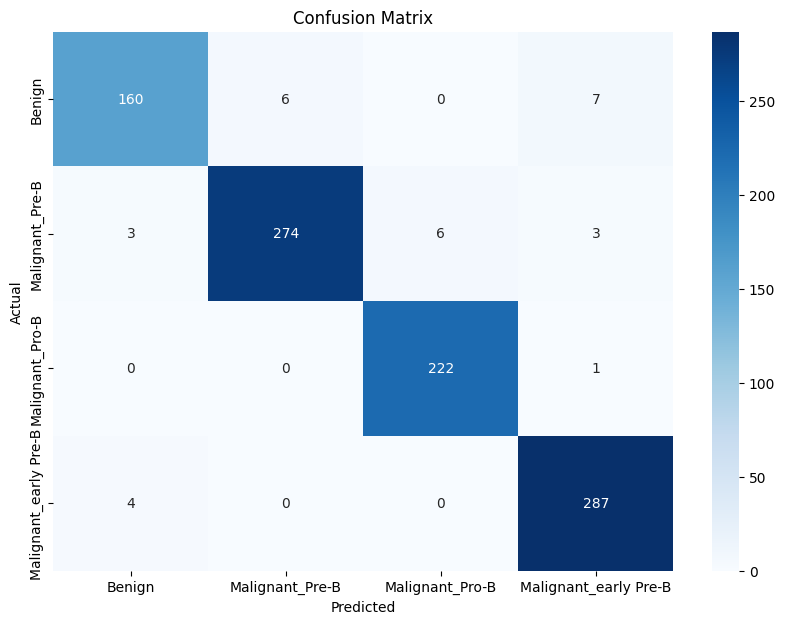

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()